# Digitizing Handwritten Shipping Manifests with OCR

This notebook demonstrates how to use Optical Character Recognition (OCR) to digitize handwritten shipping manifests. We'll use EasyOCR for text extraction and enhance the results with LLM-based post-processing to structure the output according to known shipping manifest fields.

## Setup and Installation

First, let's install the necessary packages with specific versions to ensure compatibility across different environments.

In [81]:
# Install required packages with specific versions for reproducibility
# These versions are known to work together
# !pip install easyocr==1.7.2
# !pip install pillow==10.0.0
# !pip install opencv-python==4.10.0
# !pip install matplotlib==3.8.2
# !pip install numpy==1.26.4
# !pip install requests==2.31.0
# !pip install ipywidgets==8.1.1

# Introduction to Computer Vision OCR for Handwritten Documents

This notebook provides a beginner-friendly introduction to building an OCR (Optical Character Recognition) system for digitizing handwritten shipping manifests. We'll use state-of-the-art libraries to achieve high accuracy while maintaining a simple implementation.

## What is OCR?

**OCR (Optical Character Recognition)** is a technology that converts different types of documents, such as scanned paper documents, PDF files, or images captured by a digital camera, into editable and searchable data.

Handwritten OCR is particularly challenging because:
1. Handwriting varies significantly between individuals
2. Characters may be connected or overlapping
3. Variations in pen pressure, style, and legibility
4. Potential background noise or document degradation

## What We'll Build

In this notebook, we'll build a complete OCR pipeline that:
1. Takes an image of a handwritten shipping manifest (simulated with a letter to Santa)
2. Preprocesses the image to improve OCR accuracy
3. Detects and recognizes text using multiple OCR engines (EasyOCR and PaddleOCR)
4. Post-processes the extracted text to improve accuracy
5. Uses an LLM (DeepSeek) to format and structure the extracted information
6. Provides an interactive interface for testing with your own images

## Why Multiple OCR Engines?

Different OCR engines have different strengths and weaknesses. By using multiple engines and comparing their outputs, we can:
1. Increase overall accuracy through ensemble methods
2. Provide fallback options if one engine fails
3. Compare performance across different approaches
4. Learn about different OCR technologies

# Setup and Installation

First, let's install the necessary libraries. We'll use:
- `easyocr` for primary text recognition
- `paddleocr` as an alternative OCR engine
- `opencv-python` for image preprocessing
- `matplotlib` for visualization
- `requests` for making API calls to the LLM

In [82]:
# Install required packages
# Uncomment and run this cell if you need to install these packages
!pip install easyocr opencv-python matplotlib requests pillow

In [83]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import easyocr
import requests
import json
import os
from typing import List, Dict, Any, Tuple, Optional
import re
from io import BytesIO
import base64

In [84]:
import os, getpass

# OpenAI key prompt if missing
if not os.getenv("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("🔑 Enter your OpenAI API key: ")

## Shipping Manifest JSON Schema

This schema defines the expected structure of a shipping manifest document.
The LLM will use this schema to format and validate the OCR output.

In [85]:
# Define the expected JSON schema for shipping manifest
SHIPPING_MANIFEST_SCHEMA = {
    "type": "object",
    "properties": {
        "header": {
            "type": "object",
            "properties": {
                "supplier_name": {"type": "string", "description": "Name of the supplier/vendor"},
                "vendor_number": {"type": "string", "description": "Vendor identification number"},
                "page": {"type": "string", "description": "Page number"},
                "shipping_point": {"type": "string", "description": "Origin shipping location"},
                "zip_code": {"type": "string", "description": "ZIP code of shipping point"},
                "consignment_address": {"type": "string", "description": "Destination address"},
                "date_shipped": {"type": "string", "description": "Date when shipment was sent"},
                "route_to_carrier": {"type": "string", "description": "Carrier routing information"}
            }
        },
        "items": {
            "type": "array",
            "items": {
                "type": "object",
                "properties": {
                    "store": {"type": "string", "description": "Store identifier or name"},
                    "address": {"type": "string", "description": "Store address"},
                    "cartons": {"type": "string", "description": "Number of cartons"},
                    "weight": {"type": "string", "description": "Total weight"},
                    "cube": {"type": "string", "description": "Cubic measurement"},
                    "purchase_order": {"type": "string", "description": "Purchase order number"},
                    "merchandise_description": {"type": "string", "description": "Description of merchandise"},
                    "reference": {"type": "string", "description": "Reference number or code"}
                }
            }
        },
        "totals": {
            "type": "object",
            "properties": {
                "total_cartons": {"type": "string", "description": "Total number of cartons"},
                "total_weight": {"type": "string", "description": "Total weight"},
                "total_cube": {"type": "string", "description": "Total cubic measurement"}
            }
        }
    }
}

# # Example of expected output format
# SHIPPING_MANIFEST_EXAMPLE = {
#     "header": {
#         "supplier_name": "B.I.G. Customer #1 (original)",
#         "vendor_number": "1122",
#         "page": "1",
#         "shipping_point": "Vienna, VA",
#         "zip_code": "22180",
#         "consignment_address": "for Test Company 21\n100 West Street\nFairfax, VA 22030",
#         "date_shipped": "2013/08/24",
#         "route_to_carrier": ""
#     },
#     "items": [
#         {
#             "store": "100 West Street",
#             "address": "Fairfax, VA 22030",
#             "cartons": "23",
#             "weight": "23",
#             "cube": "6133",
#             "purchase_order": "Footwear",
#             "merchandise_description": "Footwear",
#             "reference": "test17"
#         }
#     ],
#     "totals": {
#         "total_cartons": "23",
#         "total_weight": "23",
#         "total_cube": "6133"
#     }
# }

# Loading and Visualizing the Image

Let's start by loading our sample image and visualizing it. This helps us understand what we're working with and identify potential challenges.

In [86]:
# Function to load and display an image
def load_and_display_image(image_path):
    """
    Load an image from the specified path and display it

    Args:
        image_path (str): Path to the image file

    Returns:
        numpy.ndarray: The loaded image in BGR format (OpenCV default)
    """
    # Check if the image exists
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return None

    # Load the image using OpenCV
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return None

    # Convert from BGR to RGB for display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Original Image')
    plt.show()

    # Print image information
    print(f"Image dimensions: {image.shape[1]} x {image.shape[0]} pixels")
    print(f"Image type: {image.dtype}")

    return image

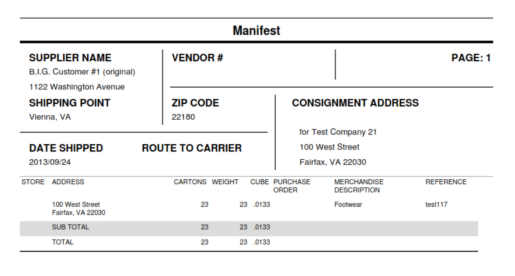

In [87]:
from PIL import Image
from io import BytesIO

# Dropbox image URL with ?dl=1 for direct download
image_url = "https://www.dropbox.com/scl/fi/uogmr1o3k37s8nntn34ii/manifest.png?rlkey=pxutzlskwihz5ytcmvjl7ut0m&st=qnnedwnc&dl=1"

# Download image
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Image Preprocessing

Before applying OCR, it's often beneficial to preprocess the image to improve text recognition accuracy. Common preprocessing techniques include:

1. **Grayscale conversion**: Simplifies the image by removing color information
2. **Noise reduction**: Removes speckles and artifacts
3. **Binarization**: Converts the image to black and white using thresholding
4. **Deskewing**: Corrects the orientation of the text
5. **Contrast enhancement**: Improves the distinction between text and background

Let's implement these preprocessing techniques:

In [88]:
# Function for image preprocessing
def preprocess_image(image, preprocessing_steps=None):
    """
    Apply various preprocessing techniques to the image

    Args:
        image (numpy.ndarray): The input image in BGR format
        preprocessing_steps (list): List of preprocessing steps to apply
            Possible values: 'grayscale', 'denoise', 'binarize', 'deskew', 'contrast'

    Returns:
        dict: Dictionary containing the original and preprocessed images
    """
    if preprocessing_steps is None:
        preprocessing_steps = ['grayscale', 'denoise', 'contrast', 'binarize']

    result = {'original': image.copy()}
    current = image.copy()

    # Apply each preprocessing step in order
    for step in preprocessing_steps:
        if step == 'grayscale':
            # Convert to grayscale
            if len(current.shape) == 3:
                current = cv2.cvtColor(current, cv2.COLOR_BGR2GRAY)
            result['grayscale'] = current.copy()

        elif step == 'denoise':
            # Apply noise reduction
            if len(current.shape) == 3:
                current = cv2.fastNlMeansDenoisingColored(current, None, 10, 10, 7, 21)
            else:
                current = cv2.fastNlMeansDenoising(current, None, 10, 7, 21)
            result['denoised'] = current.copy()

        elif step == 'binarize':
            # Convert to binary image using adaptive thresholding
            if len(current.shape) == 3:
                gray = cv2.cvtColor(current, cv2.COLOR_BGR2GRAY)
            else:
                gray = current

            # Apply adaptive thresholding
            binary = cv2.adaptiveThreshold(
                gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                cv2.THRESH_BINARY_INV, 11, 2
            )

            # Alternative: Otsu's thresholding
            # _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

            current = binary
            result['binary'] = current.copy()

        elif step == 'deskew':
            # Deskew the image to straighten text
            if len(current.shape) == 3:
                gray = cv2.cvtColor(current, cv2.COLOR_BGR2GRAY)
            else:
                gray = current

            # Calculate skew angle
            coords = np.column_stack(np.where(gray > 0))
            angle = cv2.minAreaRect(coords)[-1]

            # Adjust angle
            if angle < -45:
                angle = -(90 + angle)
            else:
                angle = -angle

            # Rotate the image to correct skew
            (h, w) = gray.shape[:2]
            center = (w // 2, h // 2)
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            current = cv2.warpAffine(gray, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

            result['deskewed'] = current.copy()

        elif step == 'contrast':
            # Enhance contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization)
            if len(current.shape) == 3:
                # Convert to LAB color space
                lab = cv2.cvtColor(current, cv2.COLOR_BGR2LAB)
                l, a, b = cv2.split(lab)

                # Apply CLAHE to L channel
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                cl = clahe.apply(l)

                # Merge channels and convert back to BGR
                merged = cv2.merge((cl, a, b))
                current = cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)
            else:
                # Apply CLAHE directly to grayscale image
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                current = clahe.apply(current)

            result['contrast_enhanced'] = current.copy()

    # Final preprocessed image is the result of the last step
    result['preprocessed'] = current

    return result

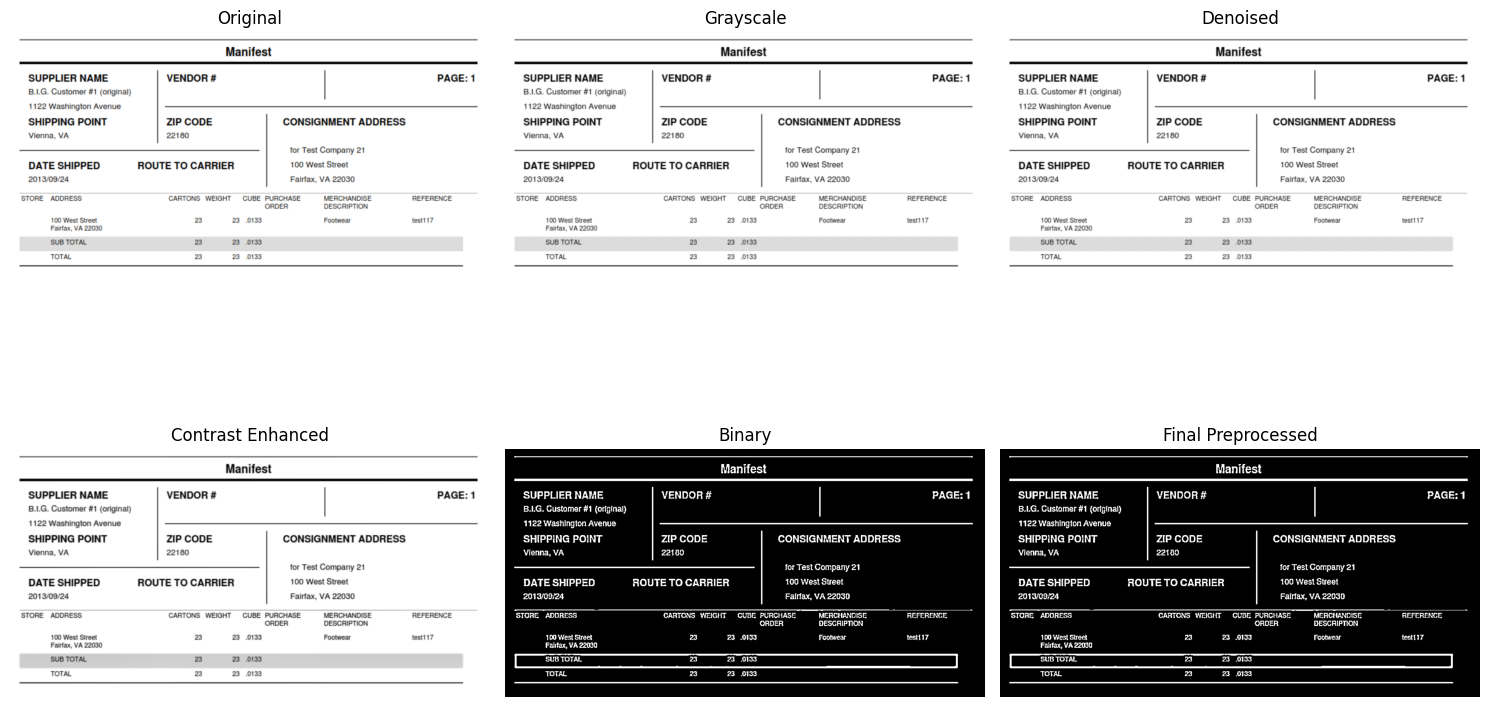

In [89]:
# Convert from PIL to OpenCV (NumPy array, BGR format)
opencv_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

# Now apply your preprocessing function
preprocessed_images = preprocess_image(opencv_img)

# Display the original and preprocessed images
plt.figure(figsize=(15, 10))

# Original image
plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(preprocessed_images['original'], cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.axis('off')

# Grayscale image
if 'grayscale' in preprocessed_images:
    plt.subplot(2, 3, 2)
    plt.imshow(preprocessed_images['grayscale'], cmap='gray')
    plt.title('Grayscale')
    plt.axis('off')

# Denoised image
if 'denoised' in preprocessed_images:
    plt.subplot(2, 3, 3)
    if len(preprocessed_images['denoised'].shape) == 3:
        plt.imshow(cv2.cvtColor(preprocessed_images['denoised'], cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(preprocessed_images['denoised'], cmap='gray')
    plt.title('Denoised')
    plt.axis('off')

# Contrast enhanced image
if 'contrast_enhanced' in preprocessed_images:
    plt.subplot(2, 3, 4)
    if len(preprocessed_images['contrast_enhanced'].shape) == 3:
        plt.imshow(cv2.cvtColor(preprocessed_images['contrast_enhanced'], cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(preprocessed_images['contrast_enhanced'], cmap='gray')
    plt.title('Contrast Enhanced')
    plt.axis('off')

# Binary image
if 'binary' in preprocessed_images:
    plt.subplot(2, 3, 5)
    plt.imshow(preprocessed_images['binary'], cmap='gray')
    plt.title('Binary')
    plt.axis('off')

# Final preprocessed image
plt.subplot(2, 3, 6)
if len(preprocessed_images['preprocessed'].shape) == 3:
    plt.imshow(cv2.cvtColor(preprocessed_images['preprocessed'], cv2.COLOR_BGR2RGB))
else:
    plt.imshow(preprocessed_images['preprocessed'], cmap='gray')
plt.title('Final Preprocessed')
plt.axis('off')

plt.tight_layout()
plt.show()

# Text Recognition with EasyOCR

Now that we have preprocessed our image, let's use EasyOCR to detect and recognize the text. EasyOCR is a Python library that uses deep learning models to detect and recognize text in images.

EasyOCR is particularly good at handling handwritten text and supports multiple languages. It uses a two-stage approach:
1. Text detection: Identifies regions in the image that contain text
2. Text recognition: Recognizes the actual text in each detected region

In [90]:
# Function to perform OCR using EasyOCR
def perform_easyocr(image, languages=['en'], gpu=False):
    """
    Perform OCR using EasyOCR

    Args:
        image (numpy.ndarray): The input image
        languages (list): List of language codes to recognize
        gpu (bool): Whether to use GPU acceleration

    Returns:
        tuple: (results, annotated_image)
            - results: List of detected text with bounding boxes and confidence scores
            - annotated_image: Image with detected text regions highlighted
    """
    # Initialize the OCR reader
    print("Initializing EasyOCR reader...")
    reader = easyocr.Reader(languages, gpu=gpu)

    # Perform OCR
    print("Performing text recognition with EasyOCR...")
    results = reader.readtext(image)

    # Create a copy of the image for annotation
    if len(image.shape) == 2:  # If grayscale, convert to BGR
        annotated_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        annotated_image = image.copy()

    # Annotate the image with detected text regions
    for (bbox, text, prob) in results:
        # Convert bbox to integers for drawing
        pts = np.array(bbox, np.int32)
        pts = pts.reshape((-1, 1, 2))

        # Draw the bounding box
        cv2.polylines(annotated_image, [pts], True, (0, 255, 0), 2)

        # Draw the text and confidence score
        cv2.putText(annotated_image, f"{text} ({prob:.2f})",
                   (int(bbox[0][0]), int(bbox[0][1] - 10)),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return results, annotated_image

Initializing EasyOCR reader...
Performing text recognition with EasyOCR...


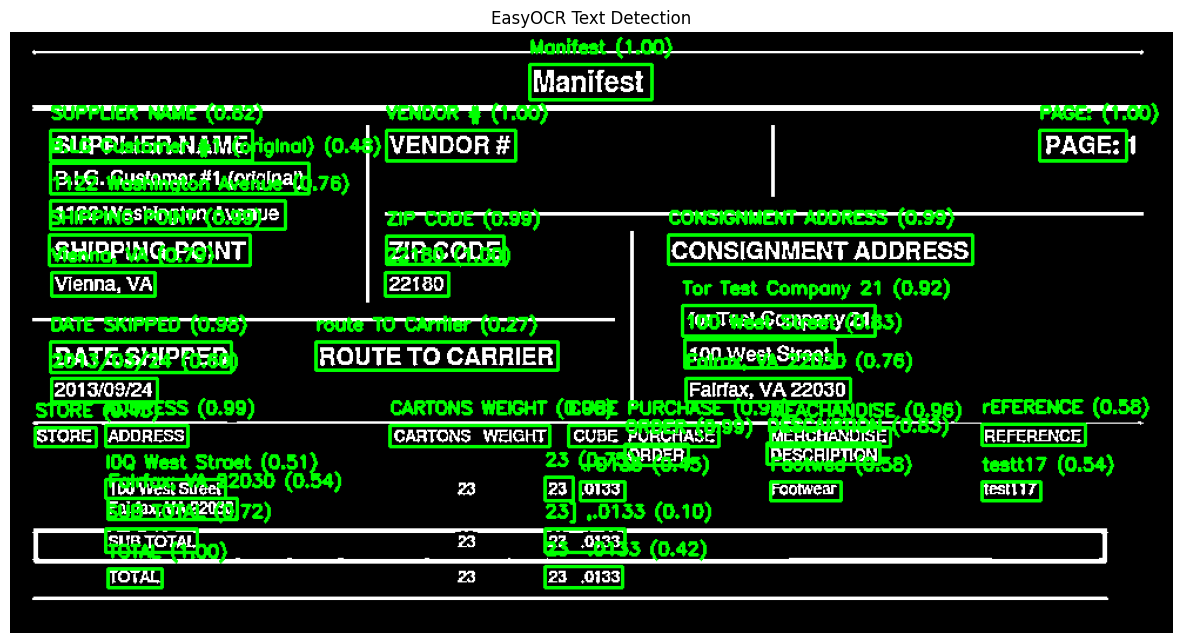

EasyOCR Recognized Text:
1. 'Manifest' (Confidence: 1.00)
2. 'SUPPLIER NAME' (Confidence: 0.82)
3. 'VENDOR #' (Confidence: 1.00)
4. 'PAGE:' (Confidence: 1.00)
5. 'B.LG Customer #1 (origlnal)' (Confidence: 0.48)
6. '1122 Washington Avenue' (Confidence: 0.76)
7. 'SHIPPING POINT' (Confidence: 0.99)
8. 'ZIP CODE' (Confidence: 0.99)
9. 'CONSIGNMENT ADDRESS' (Confidence: 0.99)
10. 'Vienna, VA' (Confidence: 0.79)
11. '22180' (Confidence: 1.00)
12. 'Tor Test Company 21' (Confidence: 0.92)
13. 'DATE SKIPPED' (Confidence: 0.98)
14. 'route TO CArriIer' (Confidence: 0.27)
15. '100 West Street' (Confidence: 0.83)
16. '2013/03/24' (Confidence: 0.60)
17. 'Falrax, VA 22030' (Confidence: 0.76)
18. 'STORE' (Confidence: 0.45)
19. 'ADDRESS' (Confidence: 0.99)
20. 'CARTONS WEIGHT' (Confidence: 0.96)
21. 'CUBE PURCHASE' (Confidence: 0.93)
22. 'MEACHANDISE' (Confidence: 0.96)
23. 'rEFERENCE' (Confidence: 0.58)
24. 'ORDER' (Confidence: 0.99)
25. 'DESCAIPTION' (Confidence: 0.83)
26. 'I0Q West Straet' (Confiden

In [91]:
# Apply EasyOCR to our preprocessed image
easyocr_results, easyocr_annotated = perform_easyocr(preprocessed_images['preprocessed'])

# Display the results
plt.figure(figsize=(15, 10))

# Display the annotated image
if len(easyocr_annotated.shape) == 3:
    plt.imshow(cv2.cvtColor(easyocr_annotated, cv2.COLOR_BGR2RGB))
else:
    plt.imshow(easyocr_annotated, cmap='gray')

plt.title('EasyOCR Text Detection')
plt.axis('off')
plt.show()

# Print the recognized text
print("EasyOCR Recognized Text:")
for i, (bbox, text, prob) in enumerate(easyocr_results):
    print(f"{i+1}. '{text}' (Confidence: {prob:.2f})")


# LLM-Enhanced OCR Processing

Now we'll use an LLM to process the EasyOCR results and structure them according to our shipping manifest schema.
This approach leverages the LLM's understanding of document structure to improve the OCR output.

# LLM-Enhanced OCR Processing with Schema Validation

Now we'll create a new function that uses an LLM to process the EasyOCR results and structure them according to our shipping manifest schema.
This approach leverages the LLM's understanding of document structure to improve and format the OCR output.

In [92]:
# Function to process OCR results with LLM using schema
def process_ocr_with_llm_schema(easyocr_results, api_key=None, model="gpt-4o"):
    """
    Process EasyOCR results using LLM with shipping manifest schema

    Args:
        easyocr_results: Results from EasyOCR
        api_key: OpenAI API key
        model: Model to use for processing (default: gpt-4o)

    Returns:
        dict: Structured shipping manifest data
    """
    # Extract text from EasyOCR results
    extracted_text = []
    for bbox, text, prob in easyocr_results:
        extracted_text.append(f"{text} (confidence: {prob:.2f})")

    # Combine all extracted text
    raw_ocr_text = "\n".join(extracted_text)

    print("Raw OCR Text:")
    print(raw_ocr_text)
    print("\n" + "="*50 + "\n")

    # Prepare the prompt for the LLM
    prompt = f"""
You are an expert at processing OCR results from shipping manifests. I will provide you with raw OCR text extracted from a shipping manifest document, along with a JSON schema that defines the expected structure.

Your task is to:
1. Parse the raw OCR text
2. Extract relevant information for each field in the schema
3. Return a properly formatted JSON object that matches the schema
4. Handle OCR errors and inconsistencies intelligently
5. If a field cannot be determined from the OCR text, use an empty string

Here is the expected JSON schema for a shipping manifest:
{json.dumps(SHIPPING_MANIFEST_SCHEMA, indent=2)}

Raw OCR Text to process:
{raw_ocr_text}

Please return ONLY a valid JSON object that matches the schema. Do not include any explanatory text or markdown formatting.
"""

    if api_key is None:
        print("No API key provided. Returning mock structured data.")
        return {
            "header": {
                "supplier_name": "[Extracted from OCR]",
                "vendor_number": "[Extracted from OCR]",
                "page": "[Extracted from OCR]",
                "shipping_point": "[Extracted from OCR]",
                "zip_code": "[Extracted from OCR]",
                "consignment_address": "[Extracted from OCR]",
                "date_shipped": "[Extracted from OCR]",
                "route_to_carrier": "[Extracted from OCR]"
            },
            "items": [
                {
                    "store": "[Extracted from OCR]",
                    "address": "[Extracted from OCR]",
                    "cartons": "[Extracted from OCR]",
                    "weight": "[Extracted from OCR]",
                    "cube": "[Extracted from OCR]",
                    "purchase_order": "[Extracted from OCR]",
                    "merchandise_description": "[Extracted from OCR]",
                    "reference": "[Extracted from OCR]"
                }
            ],
            "totals": {
                "total_cartons": "[Extracted from OCR]",
                "total_weight": "[Extracted from OCR]",
                "total_cube": "[Extracted from OCR]"
            },
            "raw_ocr_text": raw_ocr_text
        }

    try:
        # Make API call to OpenAI
        headers = {
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json"
        }

        data = {
            "model": model,
            "messages": [
                {
                    "role": "system",
                    "content": "You are an expert at processing OCR results from shipping manifests. You extract and structure information according to provided JSON schemas."
                },
                {
                    "role": "user",
                    "content": prompt
                }
            ],
            "temperature": 0.1,  # Low temperature for consistent formatting
            "max_tokens": 2000
        }

        response = requests.post(
            "https://api.openai.com/v1/chat/completions",
            headers=headers,
            json=data,
            timeout=30
        )

        if response.status_code == 200:
            result = response.json()
            llm_response = result['choices'][0]['message']['content'].strip()

            # Try to parse the JSON response
            try:
                # Handle markdown code blocks that OpenAI often returns
                json_text = llm_response.strip()
                if json_text.startswith('```json'):
                    # Extract JSON from markdown code block
                    json_text = json_text[7:]  # Remove '```json'
                    if json_text.endswith('```'):
                        json_text = json_text[:-3]  # Remove closing '```'
                elif json_text.startswith('```'):
                    # Handle generic code block
                    json_text = json_text[3:]  # Remove opening '```'
                    if json_text.endswith('```'):
                        json_text = json_text[:-3]  # Remove closing '```'

                json_text = json_text.strip()
                structured_data = json.loads(json_text)
                # Add the raw OCR text for reference
                structured_data['raw_ocr_text'] = raw_ocr_text
                return structured_data
            except json.JSONDecodeError as e:
                print(f"Error parsing LLM JSON response: {e}")
                print(f"LLM Response: {llm_response}")
                return {"error": "Failed to parse LLM response", "raw_response": llm_response, "raw_ocr_text": raw_ocr_text}
        else:
            print(f"API request failed with status {response.status_code}: {response.text}")
            return {"error": f"API request failed: {response.status_code}", "raw_ocr_text": raw_ocr_text}

    except Exception as e:
        print(f"Error processing with LLM: {e}")
        return {"error": str(e), "raw_ocr_text": raw_ocr_text}

# Using LLM for Formatting and Context Evaluation

Now that we have extracted and post-processed the text from our handwritten document, let's use an LLM (DeepSeek) to format the text and provide context evaluation. This step is particularly useful for:

1. Correcting OCR errors that our post-processing missed
2. Formatting the text into a structured format (e.g., JSON)
3. Extracting key information from the text
4. Providing context and meaning to the extracted text

We'll use DeepSeek's API for this purpose, as it provides powerful language understanding capabilities.

# Demo: Test the Schema-Based OCR Pipeline

Let's test our streamlined pipeline with the shipping manifest image.

In [93]:
# Test the new schema-based pipeline
print("Testing the EasyOCR + OpenAI GPT-4o Schema Pipeline...")
print("=" * 50)

# Convert from PIL to OpenCV format for our pipeline
opencv_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

# Apply EasyOCR to our image
easyocr_results, easyocr_annotated = perform_easyocr(opencv_img)

# Process with LLM schema validation using OpenAI GPT-4o
structured_manifest = process_ocr_with_llm_schema(easyocr_results, api_key=openai_api_key)

# Display the final structured results
print("\n" + "=" * 50)
print("FINAL STRUCTURED SHIPPING MANIFEST:")
print("=" * 50)
print(json.dumps(structured_manifest, indent=2))

Testing the EasyOCR + OpenAI GPT-4o Schema Pipeline...
Initializing EasyOCR reader...
Performing text recognition with EasyOCR...
Raw OCR Text:
Manifest (confidence: 0.87)
SUPPLIER NAME (confidence: 0.97)
VENDOR # (confidence: 1.00)
PAGE: 1 (confidence: 0.61)
B.L.G. Customer #1 (original) (confidence: 0.32)
1122 Washington Avenue (confidence: 0.79)
SHIPPING POINT (confidence: 1.00)
ZIP CODE (confidence: 0.98)
CONSIGNMENT ADDRESS (confidence: 0.90)
Vienna, VA (confidence: 0.72)
22180 (confidence: 1.00)
for Test (confidence: 0.96)
Company 21 (confidence: 0.70)
DATE SHIPPED (confidence: 1.00)
ROUTE To CARRIER (confidence: 0.63)
100 West Street (confidence: 0.93)
2013/09/24 (confidence: 1.00)
Falrfax, VA 22030 (confidence: 0.71)
STORE (confidence: 1.00)
ADDRESS (confidence: 1.00)
CARTONS (confidence: 1.00)
WEIGHT (confidence: 1.00)
CUBE (confidence: 1.00)
PURCHASE (confidence: 1.00)
MERCHANDISE (confidence: 0.99)
REFERENCE (confidence: 1.00)
ORDER (confidence: 1.00)
DESCRIPTION (confidence

# Complete OCR Pipeline

Now let's put everything together into a complete OCR pipeline that can process any handwritten document image.

In [94]:
# Function for the complete OCR pipeline
def ocr_pipeline(image_path, preprocessing_steps=None, use_llm_schema=True, openai_api_key=None, task_type="shipping_manifest"):
    """
    Complete OCR pipeline for processing shipping manifests using EasyOCR + OpenAI GPT-4o schema validation

    Args:
        image_path (str): Path to the image file
        preprocessing_steps (list): List of preprocessing steps to apply
        use_llm_schema (bool): Whether to use LLM for schema-based processing
        openai_api_key (str): OpenAI API key
        task_type (str): Type of document to process (default: shipping_manifest)

    Returns:
        dict: Results from each step of the pipeline
    """
    results = {}

    # Step 1: Load the image
    print("Step 1: Loading image...")
    image = load_and_display_image(image_path)
    if image is None:
        return {"error": "Failed to load image", "success": False}

    results["original_image"] = image

    # Step 2: Preprocess the image
    print("\nStep 2: Preprocessing image...")
    if preprocessing_steps is None:
        preprocessing_steps = ['grayscale', 'denoise', 'contrast', 'binarize']

    preprocessed_images = preprocess_image(image, preprocessing_steps)
    results["preprocessed_images"] = preprocessed_images

    # Step 3: Perform OCR with EasyOCR
    print("\nStep 3: Performing OCR with EasyOCR...")
    easyocr_results, easyocr_annotated = perform_easyocr(preprocessed_images['preprocessed'])
    results["easyocr_results"] = easyocr_results
    results["easyocr_annotated"] = easyocr_annotated

    if not easyocr_results:
        return {"error": "No text detected by EasyOCR", "success": False}

    # Step 4: Process with LLM using schema (if enabled)
    if use_llm_schema and task_type == "shipping_manifest":
        print("\nStep 4: Processing OCR results with OpenAI GPT-4o schema validation...")
        structured_manifest = process_ocr_with_llm_schema(easyocr_results, api_key=openai_api_key)
        results["structured_manifest"] = structured_manifest
        results["formatted_result"] = {
            "success": "error" not in structured_manifest,
            "formatted_text": json.dumps(structured_manifest, indent=2)
        }
    else:
        # Simple text extraction without schema
        print("\nStep 4: Extracting text without schema processing...")
        extracted_text = []
        for bbox, text, prob in easyocr_results:
            extracted_text.append(f"{text} (confidence: {prob:.2f})")

        full_text = "\n".join(extracted_text)
        results["full_text"] = full_text
        results["formatted_result"] = {
            "success": True,
            "formatted_text": full_text
        }

    results["success"] = True
    return results

In [95]:
# Test the complete pipeline on our sample image
if in_notebook:
    # Create a simple UI for testing the pipeline
    from ipywidgets import widgets
    from IPython.display import display, clear_output

    # File upload widget
    file_upload = widgets.FileUpload(
        accept='image/*',
        description='Upload Image'
    )

    # Preprocessing options
    preproc_options = widgets.SelectMultiple(
        options=['grayscale', 'denoise', 'contrast', 'binarize', 'deskew'],
        value=['grayscale', 'denoise', 'contrast', 'binarize'],
        description='Preprocessing:',
        disabled=False
    )

    # Processing options
    llm_schema_checkbox = widgets.Checkbox(value=True, description='Use LLM Schema Processing')

    # Document type dropdown
    doc_type = widgets.Dropdown(
        options=['shipping_manifest', 'document'],
        value='shipping_manifest',
        description='Document Type:'
    )

    # Run button
    run_button = widgets.Button(description='Run OCR Pipeline')
    output = widgets.Output()

    # Layout
    ui = widgets.VBox([
        widgets.HBox([file_upload]),
        widgets.HBox([preproc_options]),
        widgets.HBox([llm_schema_checkbox]),
        widgets.HBox([doc_type]),
        run_button,
        output
    ])

    # Button click handler
    def on_run_button_clicked(b):
        with output:
            clear_output()

            # Check if a file was uploaded
            if not file_upload.value:
                print("Please upload an image first.")
                return

            # Save the uploaded file
            file_data = next(iter(file_upload.value.values()))
            file_name = next(iter(file_upload.value.keys()))
            temp_path = f"temp_{file_name}"

            with open(temp_path, 'wb') as f:
                f.write(file_data['content'])

            # Run the pipeline
            pipeline_results = ocr_pipeline(
                temp_path,
                preprocessing_steps=list(preproc_options.value),
                use_llm_schema=llm_schema_checkbox.value,
                openai_api_key=openai_api_key,
                task_type=doc_type.value
            )

            # Display results
            if pipeline_results.get("success", False):
                if "formatted_result" in pipeline_results and pipeline_results["formatted_result"].get("success", False):
                    print("\nFormatted Result:")
                    print(pipeline_results["formatted_result"]["formatted_text"])
                else:
                    print("\nExtracted Text:")
                    print(pipeline_results["full_text"])
            else:
                print(f"Error: {pipeline_results.get('error', 'Unknown error')}")

    # Connect the button click event to the handler function
    run_button.on_click(on_run_button_clicked)

    # Display the UI
    display(ui)
else:
    # Command-line interface
    print("Running OCR pipeline on sample image...")
    pipeline_results = ocr_pipeline(
        "manifest.png",  # Use the downloaded image
        use_llm_schema=(openai_api_key is not None),
        openai_api_key=openai_api_key,
        task_type="shipping_manifest"
    )

    # Display results
    if pipeline_results.get("success", False):
        if "formatted_result" in pipeline_results and pipeline_results["formatted_result"].get("success", False):
            print("\nFormatted Result:")
            print(pipeline_results["formatted_result"]["formatted_text"])
        else:
            print("\nExtracted Text:")
            print(pipeline_results["full_text"])
    else:
        print(f"Error: {pipeline_results.get('error', 'Unknown error')}")

# Conclusion

In this notebook, we've built a focused OCR pipeline for digitizing shipping manifests using a modern approach that combines:

1. **EasyOCR** for reliable text extraction from handwritten documents
2. **Image preprocessing** to improve OCR accuracy with techniques like denoising and binarization
3. **LLM-based schema validation** using DeepSeek to structure OCR results according to known shipping manifest fields
4. **JSON schema definition** that provides a clear structure for the expected output

## Key Advantages of This Approach

- **Focused and Reliable**: Uses only EasyOCR, which performs well on handwritten text
- **Schema-Driven**: The LLM understands the expected structure of shipping manifests and formats accordingly
- **Error Correction**: The LLM can intelligently handle OCR errors and inconsistencies
- **Structured Output**: Returns properly formatted JSON that can be easily integrated into business systems
- **Extensible**: The schema can be easily modified for different document types

## Next Steps

To further improve this OCR system, you could:

1. Expand the schema to handle more complex shipping manifest variations
2. Add confidence scoring for extracted fields
3. Implement validation rules for specific field types (dates, numbers, etc.)
4. Add support for multi-page documents
5. Integrate with document management systems or databases
6. Add batch processing capabilities for multiple documents